# Analyze Missclassifications

In [103]:
from pathlib import Path
import json

import numpy as np
import pandas as pd

## Identify Misclassified Flows

In [105]:
# Configuration
dataset = "darpa2000"
scenario = "s1_inside"

In [106]:
# Hyperparameters
window_size = 10
model = "multi_class_lstm"
variant = "resampled"
weights = "no_class_weights"

In [113]:
processed_dir = f"../data/processed/{dataset}/{scenario}/windowed"
results_dir = f"../experiments/{dataset}/{scenario}/baselines/{model}/results"
metrics_file = f"{results_dir}/{model}_{variant}_{weights}_w{window_size}_metrics.json"

In [114]:
with open(metrics_file) as f:
    metrics = json.load(f)

misclassified_indices = metrics["misclassified_indices"]
real_flow_indices = metrics["real_flow_indices"]
mis_y_pred = metrics["y_pred"]
mis_y_true = metrics["y_true"]


In [115]:
df = pd.read_csv(
    f"../data/interim/{dataset}/{scenario}/flows_labeled/all_flows_labeled.csv"
)

df = df.sort_values("start_time").reset_index(drop=True)
df['t_rel'] = df['start_time'] - df['start_time'].min()

In [117]:
mis_df = df.iloc[real_flow_indices].copy()
mis_df["y_true"] = mis_y_true
mis_df["y_pred"] = mis_y_pred

print(f"Total misclassified flows: {len(mis_df)}")

Total misclassified flows: 27


In [118]:
mis_df.head()

,flow_id,start_time,end_time,duration,src_ip,sport,dst_ip,dport,proto,service,...,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,ip_proto,phase,t_rel,y_true,y_pred
20247,f21625,9.524404e+08,9.524404e+08,0.000486,172.16.113.169,4188,172.16.112.100,25,tcp,-,...,2,84,2,88,-,6,0,1522.620591,0,4
20539,f21650,9.524404e+08,9.524404e+08,0.000486,172.16.113.148,4365,172.16.112.100,25,tcp,-,...,2,84,2,88,-,6,0,1533.418943,0,4
20670,f21659,9.524404e+08,9.524404e+08,0.000334,172.16.112.194,4366,172.16.112.100,25,tcp,-,...,2,84,1,44,-,6,0,1539.186116,0,4
23250,f23446,9.524413e+08,9.524413e+08,0.064471,135.13.216.191,8,172.16.113.169,0,icmp,-,...,9,342,0,0,-,1,0,2405.107653,0,3
24389,f24620,9.524419e+08,9.524419e+08,0.064262,172.16.113.105,8,197.182.91.233,0,icmp,-,...,8,304,8,304,-,1,0,2969.314762,0,2


In [112]:
def create_phase_boundaries(df, sort_column='t_rel'):
    phase_bounds_df = (
        df.groupby('phase')
        .agg(
            first_occurrence=(sort_column, 'min'),
            last_occurrence=(sort_column, 'max')
        )
        .reset_index()
    )
    return phase_bounds_df

In [122]:
phase_bounds_time = create_phase_boundaries(df)
phase_bounds_time

,phase,first_occurrence,last_occurrence
0,0,0.000000,11649.756589
1,1,1799.665435,1824.341042
2,2,2790.877254,3333.974143
3,3,4294.134775,4402.837414
4,4,5305.272464,5357.444592
5,5,7478.960660,8383.254878


In [123]:
phase_bounds_flow_id = create_phase_boundaries(df, sort_column='flow_id')
phase_bounds_flow_id

,phase,first_occurrence,last_occurrence
0,0,f0,f9999
1,1,f21870,f21931
2,2,f24194,f26394
3,3,f29030,f29210
4,4,f31940,f33504
5,5,f100000,f99999


In [124]:
# df['flow_num'] = df['flow_id'].str.replace('f', '').astype(int)
# df = df.sort_values('flow_num')
# df.head()


In [125]:
# mis_df['flow_num'] = mis_df['flow_id'].str.replace('f', '').astype(int)
# mis_df = mis_df.sort_values('flow_num')
# mis_df

## Low Level Analysis

In [126]:
# Manually inspect misclassified flows
mis_df

,flow_id,start_time,end_time,duration,src_ip,sport,dst_ip,dport,proto,service,...,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,ip_proto,phase,t_rel,y_true,y_pred
20247,f21625,9.524404e+08,9.524404e+08,0.000486,172.16.113.169,4188,172.16.112.100,25,tcp,-,...,2,84,2,88,-,6,0,1522.620591,0,4
20539,f21650,9.524404e+08,9.524404e+08,0.000486,172.16.113.148,4365,172.16.112.100,25,tcp,-,...,2,84,2,88,-,6,0,1533.418943,0,4
20670,f21659,9.524404e+08,9.524404e+08,0.000334,172.16.112.194,4366,172.16.112.100,25,tcp,-,...,2,84,1,44,-,6,0,1539.186116,0,4
23250,f23446,9.524413e+08,9.524413e+08,0.064471,135.13.216.191,8,172.16.113.169,0,icmp,-,...,9,342,0,0,-,1,0,2405.107653,0,3
24389,f24620,9.524419e+08,9.524419e+08,0.064262,172.16.113.105,8,197.182.91.233,0,icmp,-,...,8,304,8,304,-,1,0,2969.314762,0,2
24688,f25405,9.524419e+08,9.524420e+08,55.095633,202.77.162.213,55485,172.16.113.105,111,udp,-,...,12,1008,0,0,-,17,2,3033.181850,2,3
31613,f31935,9.524441e+08,9.524441e+08,0.039273,194.27.251.21,8,172.16.112.194,0,icmp,-,...,6,228,6,228,-,1,0,5243.632337,0,1
31662,f32132,9.524442e+08,9.524442e+08,0.000000,172.16.112.194,0,197.218.177.69,8,icmp,-,...,1,38,0,0,-,1,0,5262.514702,0,1
39376,f39350,9.524464e+08,9.524464e+08,0.130358,172.16.116.201,14465,199.95.74.90,80,tcp,http,...,13,668,24,30867,-,6,0,7495.555601,0,5
39483,f39454,9.524464e+08,9.524464e+08,0.000658,172.16.115.20,1020,202.77.162.213,1022,tcp,-,...,2,80,2,80,-,6,5,7528.056140,5,4


### Look into phase 5 misclassifications

In [130]:
start_index = 114608
indices = range(start_index, start_index+20)
df_filtered = df.iloc[indices]
df_filtered

,flow_id,start_time,end_time,duration,src_ip,sport,dst_ip,dport,proto,service,...,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,ip_proto,phase,t_rel
114608,f114583,9.524469e+08,9.524469e+08,0.052641,172.16.115.5,22829,131.84.1.31,80,tcp,http,...,0,ShADadfF,7,581,9,6530,-,6,5,8040.431538
114609,f114591,9.524469e+08,9.524469e+08,0.000839,172.16.115.5,1081,172.16.115.20,53,udp,dns,...,0,Dd,1,56,1,116,-,17,0,8040.485207
114610,f114584,9.524469e+08,9.524469e+08,0.095386,172.16.115.5,22893,131.84.1.31,80,tcp,http,...,0,ShADadfF,11,756,18,21837,-,6,5,8040.486750
114611,f114592,9.524469e+08,9.524469e+08,0.000778,172.16.115.5,1082,172.16.115.20,53,udp,dns,...,0,Dd,1,56,1,116,-,17,0,8040.583206
114612,f114585,9.524469e+08,9.524469e+08,0.078284,172.16.115.5,22956,131.84.1.31,80,tcp,http,...,0,ShADdfFa,9,659,12,14998,-,6,5,8040.584752
114613,f114593,9.524469e+08,9.524469e+08,0.000805,172.16.115.5,1083,172.16.115.20,53,udp,dns,...,0,Dd,1,56,1,116,-,17,0,8040.664130
114614,f114586,9.524469e+08,9.524469e+08,0.042209,172.16.115.5,23020,131.84.1.31,80,tcp,http,...,0,ShADdfFa,6,542,6,5082,-,6,5,8040.665718
114615,f114594,9.524469e+08,9.524469e+08,0.000778,172.16.115.5,1084,172.16.115.20,53,udp,dns,...,0,Dd,1,56,1,116,-,17,0,8040.708929
114616,f114587,9.524469e+08,9.524469e+08,0.053722,172.16.115.5,23083,131.84.1.31,80,tcp,http,...,0,ShADadfF,7,583,9,6321,-,6,5,8040.710396
114617,f114636,9.524469e+08,9.524469e+08,0.000000,172.16.112.1,123,172.16.112.255,123,udp,ntp,...,0,D,1,76,0,0,-,17,0,8044.669990


In [131]:
dst_ip = "131.84.1.31"
df_filtered_dst_ip = df[df["dst_ip"] == dst_ip]

phase_counts = df_filtered_dst_ip["phase"].value_counts().sort_index()
print(phase_counts)

phase
0        7
5    73443
Name: count, dtype: int64


## Plot

In [ ]:
import matplotlib.pyplot as plt

In [138]:
phase_bounds_no0 = phase_bounds_time[phase_bounds_time['phase'] != 0]
phase_bounds_no0

,phase,first_occurrence,last_occurrence
1,1,1799.665435,1824.341042
2,2,2790.877254,3333.974143
3,3,4294.134775,4402.837414
4,4,5305.272464,5357.444592
5,5,7478.960660,8383.254878


# TODO: fix things from here on

In [ ]:
phase_start = (
    df[df['phase'] > 0]
    .groupby('phase')['flow_num']
    .min()
    .to_dict()
)

In [89]:
def is_temporally_impossible(row, phase_start):
    true_phase = row['phase']
    pred_phase = row['y_pred']
    flow_time = row['flow_num']
    
    # Ignore correct predictions
    if true_phase == pred_phase:
        return False
    
    # Benign predicted as attack before attack started
    if pred_phase > 0:
        if pred_phase in phase_start:
            return flow_time < phase_start[pred_phase]
    
    return False

In [99]:
mis_df['t_rel'] = mis_df['start_time'] - df['start_time'].min()
mis_df.head()

,flow_id,start_time,end_time,duration,src_ip,sport,dst_ip,dport,proto,service,...,resp_pkts,resp_ip_bytes,tunnel_parents,ip_proto,phase,y_true,y_pred,flow_num,impossible,t_rel
20247,f21625,9.524404e+08,9.524404e+08,0.000486,172.16.113.169,4188,172.16.112.100,25,tcp,-,...,2,88,-,6,0,0,4,21625,True,1522.620591
20539,f21650,9.524404e+08,9.524404e+08,0.000486,172.16.113.148,4365,172.16.112.100,25,tcp,-,...,2,88,-,6,0,0,4,21650,True,1533.418943
20670,f21659,9.524404e+08,9.524404e+08,0.000334,172.16.112.194,4366,172.16.112.100,25,tcp,-,...,1,44,-,6,0,0,4,21659,True,1539.186116
23250,f23446,9.524413e+08,9.524413e+08,0.064471,135.13.216.191,8,172.16.113.169,0,icmp,-,...,0,0,-,1,0,0,3,23446,True,2405.107653
24389,f24620,9.524419e+08,9.524419e+08,0.064262,172.16.113.105,8,197.182.91.233,0,icmp,-,...,8,304,-,1,0,0,2,24620,False,2969.314762


In [100]:
mis_df['impossible'] = mis_df.apply(
    is_temporally_impossible,
    axis=1,
    phase_start=phase_start
)

wrong = mis_df[mis_df['phase'] != mis_df['y_pred']]
impossible = wrong[wrong['impossible']]
plausible = wrong[~wrong['impossible']]

In [101]:
if len(wrong) > 0:
    violation_rate = len(impossible) / len(wrong)
else:
    violation_rate = 0

print(f"Total wrong predictions: {len(wrong)}")
print(f"Temporally impossible: {len(impossible)}")
print(f"Violation rate: {violation_rate:.2%}")

Total wrong predictions: 27
Temporally impossible: 6
Violation rate: 22.22%


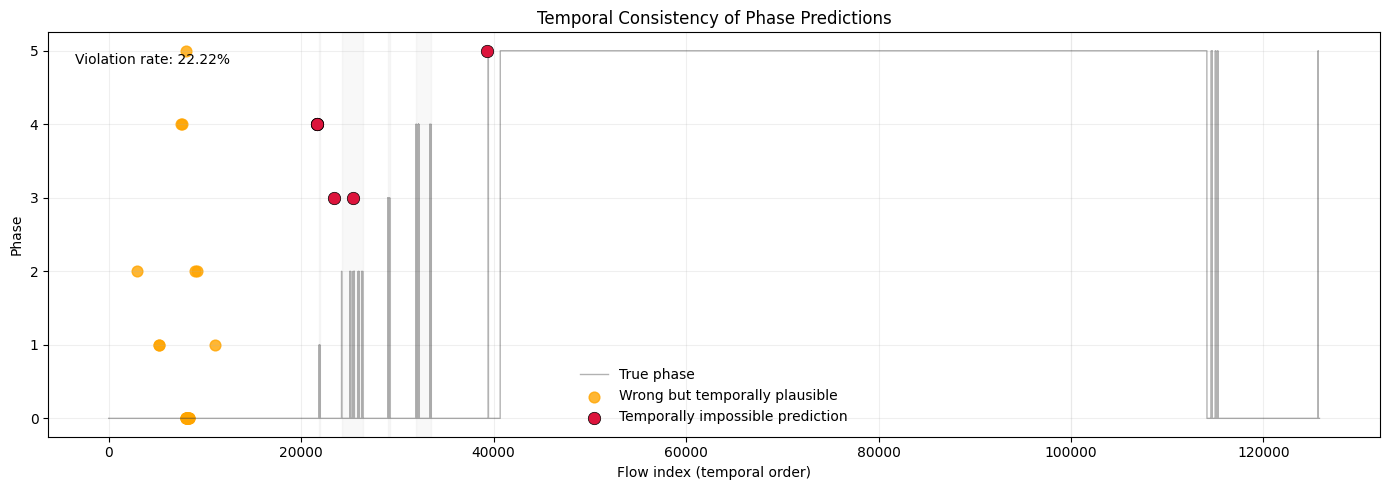

In [102]:
plt.figure(figsize=(14, 5))

# --- True phase line ---
plt.plot(
    df['flow_num'],
    df['phase'],
    color='black',
    linewidth=1,
    alpha=0.3,
    label="True phase"
)

# --- Shaded phase intervals ---
for _, row in phase_bounds_no0.iterrows():
    plt.axvspan(
        row['first_num'],
        row['last_num'],
        alpha=0.05,
        color='gray'
    )

# --- Plausible errors ---
plt.scatter(
    plausible['t_rel'],
    plausible['y_pred'],
    c='orange',
    s=60,
    alpha=0.8,
    label='Wrong but temporally plausible'
)

# --- Impossible errors ---
plt.scatter(
    impossible['flow_num'],
    impossible['y_pred'],
    c='crimson',
    s=80,
    edgecolor='black',
    linewidth=0.5,
    label='Temporally impossible prediction',
    zorder=3
)

# --- Cosmetics ---
plt.xlabel("Flow index (temporal order)")
plt.ylabel("Phase")
plt.title("Temporal Consistency of Phase Predictions")

plt.yticks(sorted(df['phase'].unique()))
plt.grid(alpha=0.2)

plt.text(
    0.02,
    0.95,
    f"Violation rate: {violation_rate:.2%}",
    transform=plt.gca().transAxes,
    verticalalignment='top'
)

plt.legend(frameon=False)
plt.tight_layout()
plt.show()

## Plot #2

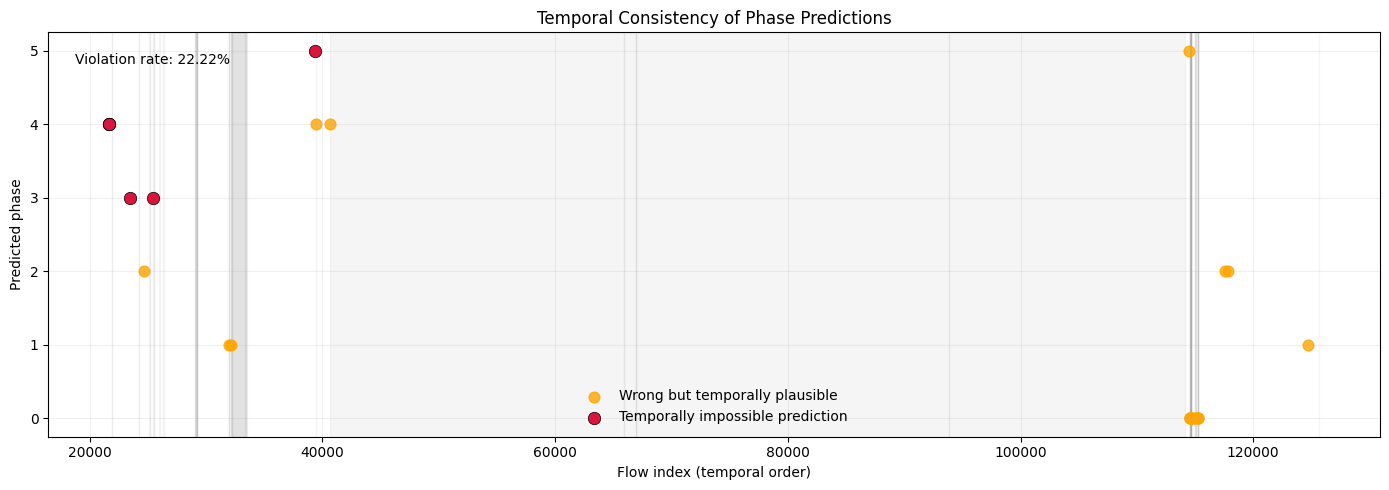

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



# ------------------------------------------------------------
# 2️⃣ Detect contiguous phase segments
# ------------------------------------------------------------

segments = []

current_phase = df.loc[0, 'phase']
start = df.loc[0, 'flow_num']

for i in range(1, len(df)):
    phase_now = df.loc[i, 'phase']
    flow_now = df.loc[i, 'flow_num']
    
    if phase_now != current_phase:
        end = df.loc[i-1, 'flow_num']
        segments.append((current_phase, start, end))
        current_phase = phase_now
        start = flow_now

# append last segment
segments.append((current_phase, start, df.loc[len(df)-1, 'flow_num']))

# ------------------------------------------------------------
# 3️⃣ Temporal impossibility logic
# ------------------------------------------------------------

phase_start = (
    df[df['phase'] > 0]
    .groupby('phase')['flow_num']
    .min()
    .to_dict()
)

def is_temporally_impossible(row, phase_start):
    true_phase = row['phase']
    pred_phase = row['y_pred']
    flow_time = row['flow_num']
    
    if true_phase == pred_phase:
        return False
    
    if pred_phase > 0 and pred_phase in phase_start:
        return flow_time < phase_start[pred_phase]
    
    return False

mis_df['impossible'] = mis_df.apply(
    is_temporally_impossible,
    axis=1,
    phase_start=phase_start
)

wrong = mis_df[mis_df['phase'] != mis_df['y_pred']]
impossible = wrong[wrong['impossible']]
plausible = wrong[~wrong['impossible']]

violation_rate = len(impossible) / len(wrong) if len(wrong) > 0 else 0

# ------------------------------------------------------------
# 4️⃣ Plot
# ------------------------------------------------------------

plt.figure(figsize=(14, 5))

# --- Shaded contiguous attack segments ---
for phase, start, end in segments:
    if phase != 0:
        plt.axvspan(
            start,
            end,
            alpha=0.08,
            color='gray'
        )

# --- Plausible errors ---
plt.scatter(
    plausible['flow_num'],
    plausible['y_pred'],
    c='orange',
    s=60,
    alpha=0.8,
    label='Wrong but temporally plausible'
)

# --- Impossible errors ---
plt.scatter(
    impossible['flow_num'],
    impossible['y_pred'],
    c='crimson',
    s=80,
    edgecolor='black',
    linewidth=0.5,
    label='Temporally impossible prediction',
    zorder=3
)

# --- Cosmetics ---
plt.xlabel("Flow index (temporal order)")
plt.ylabel("Predicted phase")
plt.title("Temporal Consistency of Phase Predictions")

plt.yticks(sorted(df['phase'].unique()))
plt.grid(alpha=0.2)

plt.text(
    0.02,
    0.95,
    f"Violation rate: {violation_rate:.2%}",
    transform=plt.gca().transAxes,
    verticalalignment='top'
)

plt.legend(frameon=False)
plt.tight_layout()
plt.show()

## Analyze the misclassified flows

We are specifically interested in flows that were wrongly classified as belonging to a later phase than their true phase. E.g., if a normal flow appearing in the recon phase where classified as ddos, or a recon flow being misclassified as ddos. If this is the case, it showcases a potential benefit of neuro-symbolic AI as the logic can enforce temporal consistency in classification.

In [89]:
mis_df["start_time"] = pd.to_datetime(mis_df["start_time"])
mis_df.sort_values("start_time").head()

,flow_id,start_time,end_time,duration,src_ip,sport,dst_ip,dport,proto,service,...,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,ip_proto,phase
20247,f21625,1970-01-01 00:00:00.952440419,9.524404e+08,0.000486,172.16.113.169,4188,172.16.112.100,25,tcp,-,...,T,0,ShA,2,84,2,88,-,6,0
20539,f21650,1970-01-01 00:00:00.952440429,9.524404e+08,0.000486,172.16.113.148,4365,172.16.112.100,25,tcp,-,...,T,0,ShA,2,84,2,88,-,6,0
20670,f21659,1970-01-01 00:00:00.952440435,9.524404e+08,0.000334,172.16.112.194,4366,172.16.112.100,25,tcp,-,...,T,0,ShA,2,84,1,44,-,6,0
23250,f23446,1970-01-01 00:00:00.952441301,9.524413e+08,0.064471,135.13.216.191,8,172.16.113.169,0,icmp,-,...,T,0,-,9,342,0,0,-,1,0
24389,f24620,1970-01-01 00:00:00.952441865,9.524419e+08,0.064262,172.16.113.105,8,197.182.91.233,0,icmp,-,...,F,0,-,8,304,8,304,-,1,0


<Axes: >

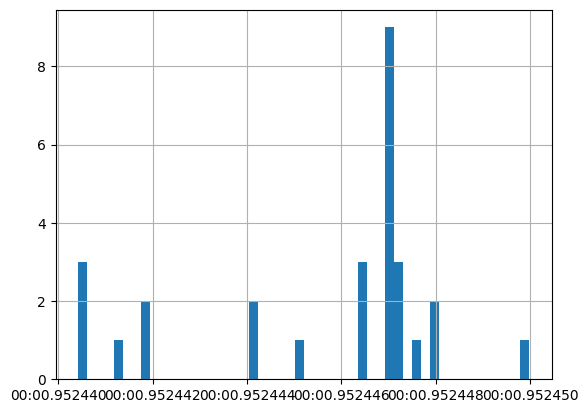

In [90]:
# Plot the distribution of start times for the misclassified flows
mis_df["start_time"].hist(bins=50)


In [91]:
# Errors per phase
mis_df["phase"].value_counts()

phase
5    14
0    13
2     1
Name: count, dtype: int64

In [92]:
benign_flows = mis_df[mis_df['phase'] == 0]
benign_flows

,flow_id,start_time,end_time,duration,src_ip,sport,dst_ip,dport,proto,service,...,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,ip_proto,phase
20247,f21625,1970-01-01 00:00:00.952440419,9.524404e+08,0.000486,172.16.113.169,4188,172.16.112.100,25,tcp,-,...,T,0,ShA,2,84,2,88,-,6,0
20539,f21650,1970-01-01 00:00:00.952440429,9.524404e+08,0.000486,172.16.113.148,4365,172.16.112.100,25,tcp,-,...,T,0,ShA,2,84,2,88,-,6,0
20670,f21659,1970-01-01 00:00:00.952440435,9.524404e+08,0.000334,172.16.112.194,4366,172.16.112.100,25,tcp,-,...,T,0,ShA,2,84,1,44,-,6,0
23250,f23446,1970-01-01 00:00:00.952441301,9.524413e+08,0.064471,135.13.216.191,8,172.16.113.169,0,icmp,-,...,T,0,-,9,342,0,0,-,1,0
24389,f24620,1970-01-01 00:00:00.952441865,9.524419e+08,0.064262,172.16.113.105,8,197.182.91.233,0,icmp,-,...,F,0,-,8,304,8,304,-,1,0
31613,f31935,1970-01-01 00:00:00.952444140,9.524441e+08,0.039273,194.27.251.21,8,172.16.112.194,0,icmp,-,...,T,0,-,6,228,6,228,-,1,0
31662,f32132,1970-01-01 00:00:00.952444158,9.524442e+08,0.000000,172.16.112.194,0,197.218.177.69,8,icmp,-,...,F,0,-,1,38,0,0,-,1,0
35497,f35563,1970-01-01 00:00:00.952445018,9.524451e+08,35.003224,172.16.115.1,3,172.16.115.20,3,icmp,-,...,T,0,-,4,224,0,0,-,1,0
113315,f40029,1970-01-01 00:00:00.952446498,9.524465e+08,0.000000,172.16.112.194,0,172.16.115.20,8,icmp,-,...,T,0,-,1,84,0,0,-,1,0
116336,f116608,1970-01-01 00:00:00.952447621,9.524477e+08,37.916153,194.7.248.153,50013,172.16.112.194,23,tcp,-,...,T,0,ShADadFf,170,6975,126,52906,-,6,0


In [97]:
mis_df["y_pred"] = mis_y_pred
mis_df

,flow_id,start_time,end_time,duration,src_ip,sport,dst_ip,dport,proto,service,...,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,ip_proto,phase,y_pred
20247,f21625,1970-01-01 00:00:00.952440419,9.524404e+08,0.000486,172.16.113.169,4188,172.16.112.100,25,tcp,-,...,0,ShA,2,84,2,88,-,6,0,4
20539,f21650,1970-01-01 00:00:00.952440429,9.524404e+08,0.000486,172.16.113.148,4365,172.16.112.100,25,tcp,-,...,0,ShA,2,84,2,88,-,6,0,4
20670,f21659,1970-01-01 00:00:00.952440435,9.524404e+08,0.000334,172.16.112.194,4366,172.16.112.100,25,tcp,-,...,0,ShA,2,84,1,44,-,6,0,4
23250,f23446,1970-01-01 00:00:00.952441301,9.524413e+08,0.064471,135.13.216.191,8,172.16.113.169,0,icmp,-,...,0,-,9,342,0,0,-,1,0,1
24389,f24620,1970-01-01 00:00:00.952441865,9.524419e+08,0.064262,172.16.113.105,8,197.182.91.233,0,icmp,-,...,0,-,8,304,8,304,-,1,0,2
24688,f25405,1970-01-01 00:00:00.952441929,9.524420e+08,55.095633,202.77.162.213,55485,172.16.113.105,111,udp,-,...,0,D,12,1008,0,0,-,17,2,3
31613,f31935,1970-01-01 00:00:00.952444140,9.524441e+08,0.039273,194.27.251.21,8,172.16.112.194,0,icmp,-,...,0,-,6,228,6,228,-,1,0,1
31662,f32132,1970-01-01 00:00:00.952444158,9.524442e+08,0.000000,172.16.112.194,0,197.218.177.69,8,icmp,-,...,0,-,1,38,0,0,-,1,0,1
35497,f35563,1970-01-01 00:00:00.952445018,9.524451e+08,35.003224,172.16.115.1,3,172.16.115.20,3,icmp,-,...,0,-,4,224,0,0,-,1,0,2
39483,f39454,1970-01-01 00:00:00.952446424,9.524464e+08,0.000658,172.16.115.20,1020,202.77.162.213,1022,tcp,-,...,0,FafA,2,80,2,80,-,6,5,4


In [74]:
# Check if any phase 5 flows appeared
phase = 5
before_first_benign = mis_df[mis_df['flow_id'] < benign_flows.iloc[0]['flow_id']]
phase5_before = before_first_benign[before_first_benign['phase'] == phase]

print(f"Benign misclassification flow_ids: {benign_flows['flow_id'].tolist()}")
print(f"Phase {phase} flows before first benign misclassification: {len(phase5_before)}")
phase5_before.head()

Benign misclassification flow_ids: ['f39831', 'f39829', 'f39832', 'f114510']
Phase 5 flows before first benign misclassification: 13


,flow_id,start_time,end_time,duration,src_ip,sport,dst_ip,dport,proto,service,...,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,ip_proto,phase
39483,f39454,1970-01-01 00:00:00.952446424,9.524464e+08,0.000658,172.16.115.20,1020,202.77.162.213,1022,tcp,-,...,F,0,FafA,2,80,2,80,-,6,5
114608,f114583,1970-01-01 00:00:00.952446936,9.524469e+08,0.052641,172.16.115.5,22829,131.84.1.31,80,tcp,http,...,F,0,ShADadfF,7,581,9,6530,-,6,5
114612,f114585,1970-01-01 00:00:00.952446937,9.524469e+08,0.078284,172.16.115.5,22956,131.84.1.31,80,tcp,http,...,F,0,ShADdfFa,9,659,12,14998,-,6,5
114614,f114586,1970-01-01 00:00:00.952446937,9.524469e+08,0.042209,172.16.115.5,23020,131.84.1.31,80,tcp,http,...,F,0,ShADdfFa,6,542,6,5082,-,6,5
114616,f114587,1970-01-01 00:00:00.952446937,9.524469e+08,0.053722,172.16.115.5,23083,131.84.1.31,80,tcp,http,...,F,0,ShADadfF,7,583,9,6321,-,6,5


In [76]:
ddos_flows = mis_df[mis_df['phase'] == 5]
ddos_flows

,flow_id,start_time,end_time,duration,src_ip,sport,dst_ip,dport,proto,service,...,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,ip_proto,phase
39483,f39454,1970-01-01 00:00:00.952446424,9.524464e+08,0.000658,172.16.115.20,1020,202.77.162.213,1022,tcp,-,...,F,0,FafA,2,80,2,80,-,6,5
114608,f114583,1970-01-01 00:00:00.952446936,9.524469e+08,0.052641,172.16.115.5,22829,131.84.1.31,80,tcp,http,...,F,0,ShADadfF,7,581,9,6530,-,6,5
114612,f114585,1970-01-01 00:00:00.952446937,9.524469e+08,0.078284,172.16.115.5,22956,131.84.1.31,80,tcp,http,...,F,0,ShADdfFa,9,659,12,14998,-,6,5
114614,f114586,1970-01-01 00:00:00.952446937,9.524469e+08,0.042209,172.16.115.5,23020,131.84.1.31,80,tcp,http,...,F,0,ShADdfFa,6,542,6,5082,-,6,5
114616,f114587,1970-01-01 00:00:00.952446937,9.524469e+08,0.053722,172.16.115.5,23083,131.84.1.31,80,tcp,http,...,F,0,ShADadfF,7,583,9,6321,-,6,5
114647,f114621,1970-01-01 00:00:00.952446986,9.524470e+08,0.030979,172.16.116.201,23464,131.84.1.31,80,tcp,http,...,F,0,ShADdfFa,5,394,4,2432,-,6,5
114655,f114626,1970-01-01 00:00:00.952446987,9.524470e+08,0.050499,172.16.116.201,23655,131.84.1.31,80,tcp,http,...,F,0,ShADdfFa,6,425,6,5082,-,6,5
114661,f114640,1970-01-01 00:00:00.952446999,9.524470e+08,0.050664,172.16.115.5,23782,131.84.1.31,80,tcp,http,...,F,0,ShADdfFa,7,598,8,7992,-,6,5
115033,f115007,1970-01-01 00:00:00.952447097,9.524471e+08,0.078300,172.16.115.5,24713,131.84.1.31,80,tcp,http,...,F,0,ShADadfF,7,556,9,7092,-,6,5
115037,f115009,1970-01-01 00:00:00.952447097,9.524471e+08,0.072933,172.16.115.5,24715,131.84.1.31,80,tcp,http,...,F,0,ShADdfFa,9,684,11,13067,-,6,5
